In [3]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [4]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [5]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-bpe"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-bpe", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-bpe", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [6]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

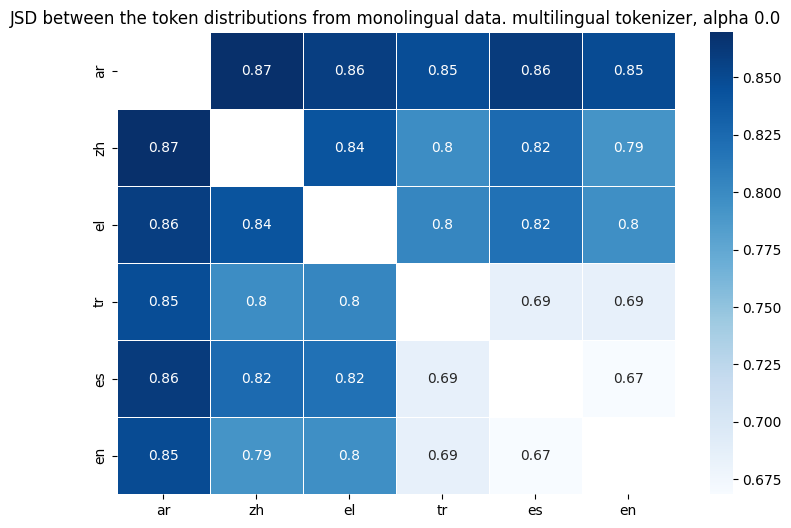

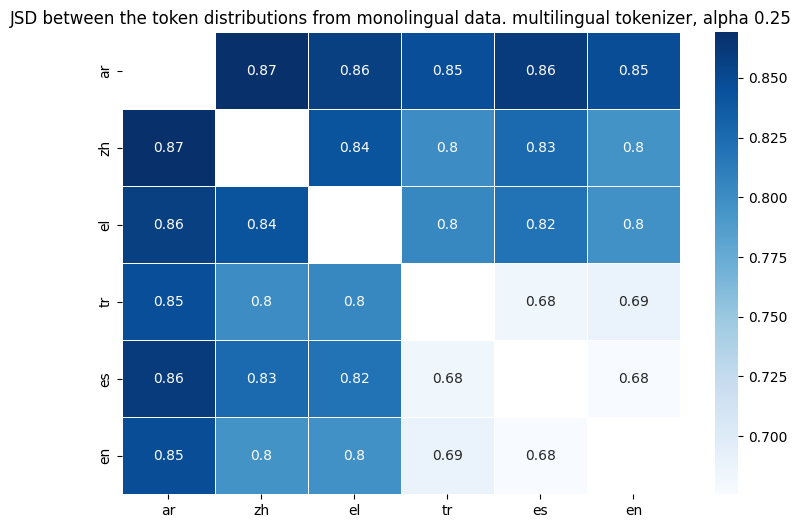

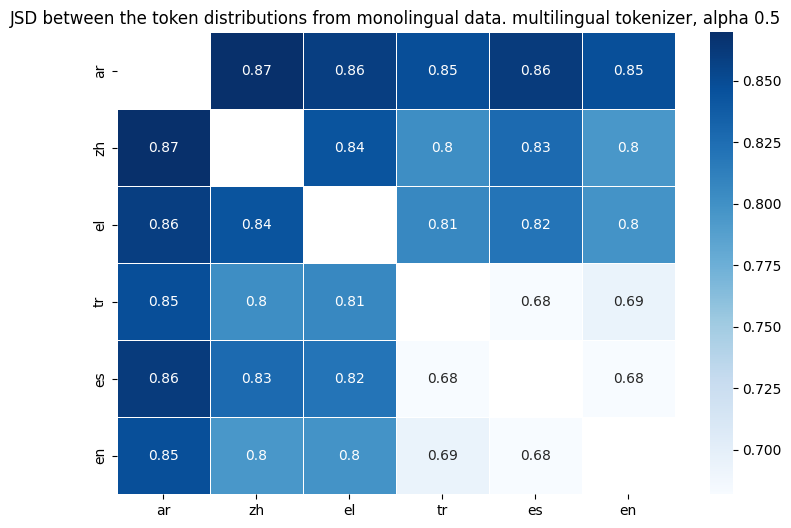

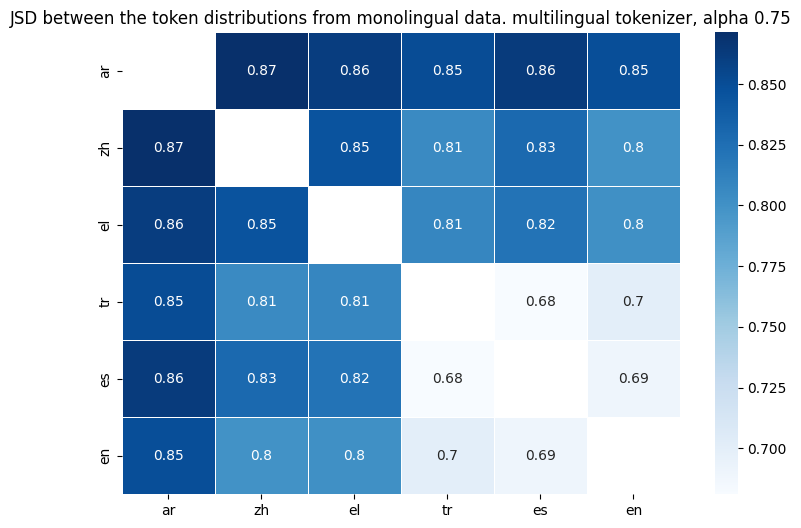

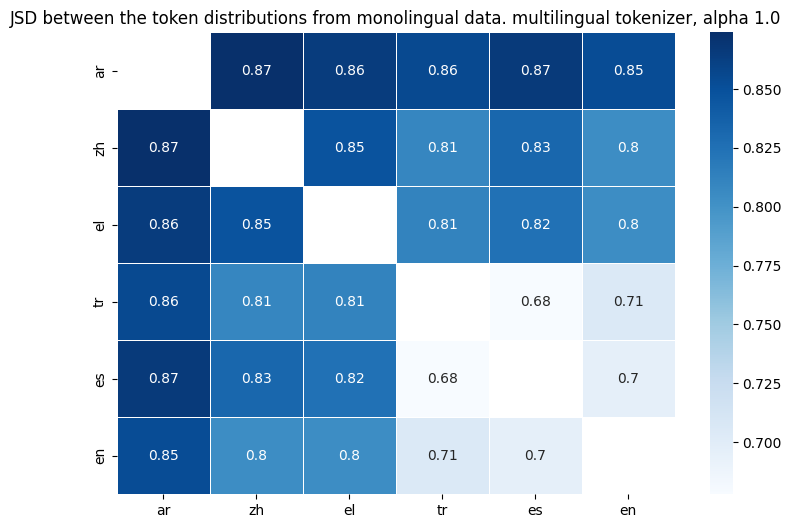

In [7]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2], base=2.) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

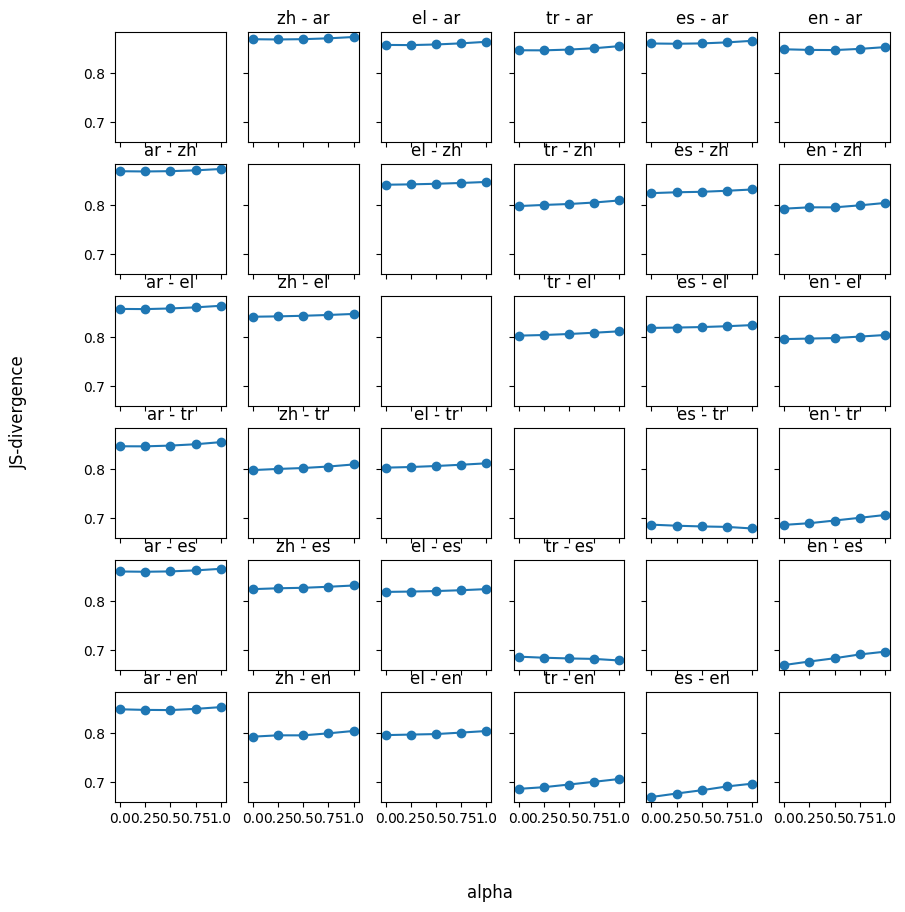

In [8]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


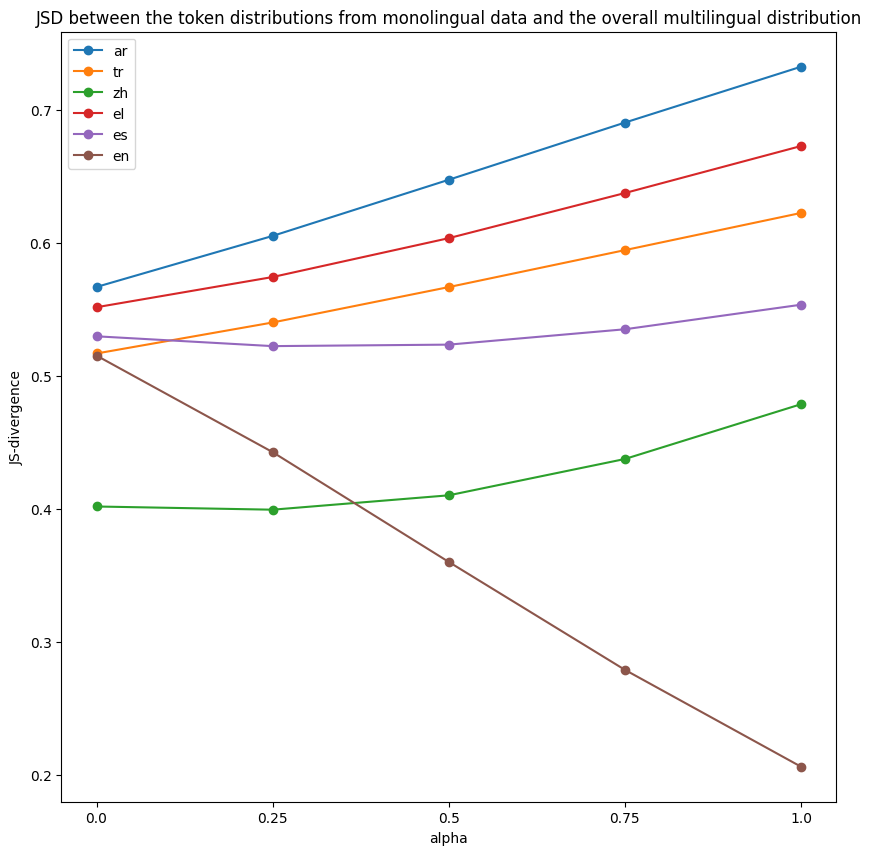

In [9]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

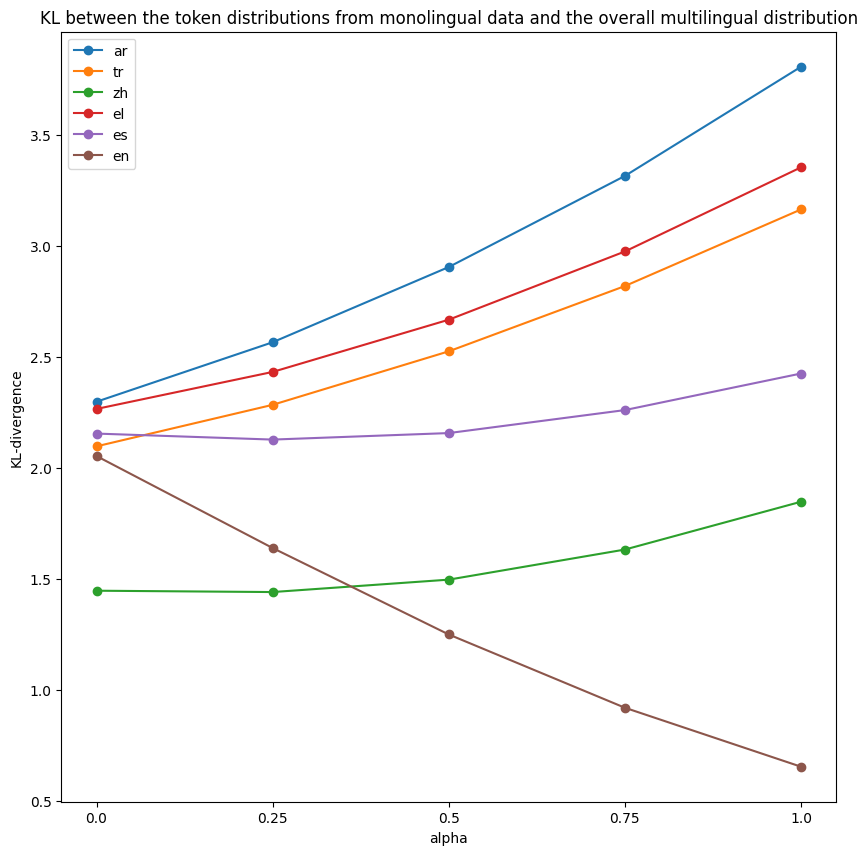

In [10]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.)

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

## Tokenizer profile plot PDFs

<Figure size 640x480 with 0 Axes>

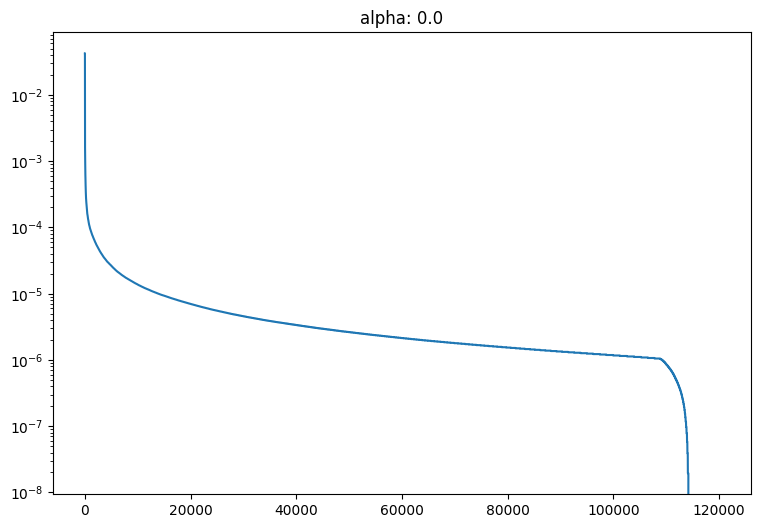

<Figure size 640x480 with 0 Axes>

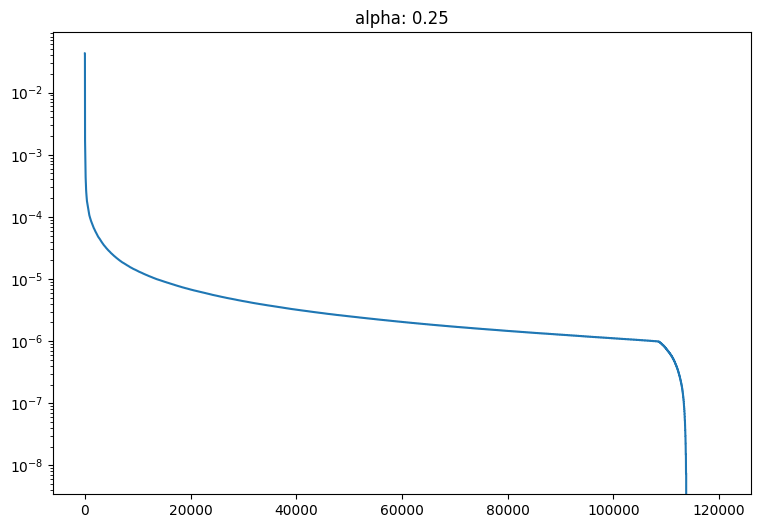

<Figure size 640x480 with 0 Axes>

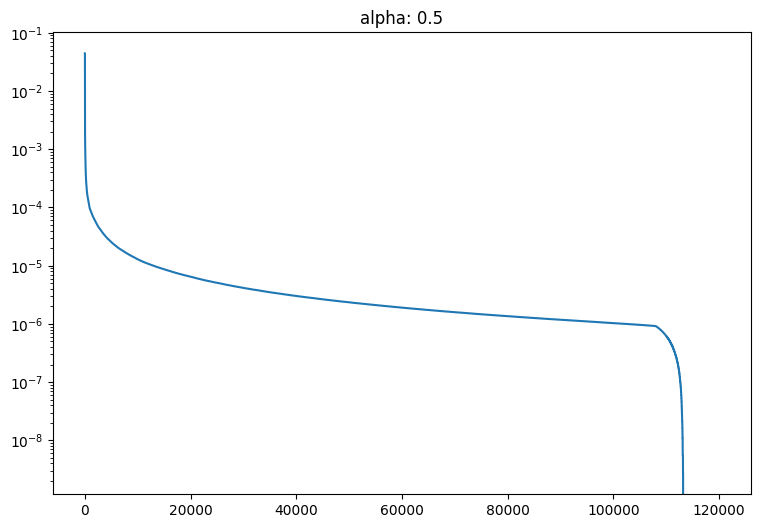

<Figure size 640x480 with 0 Axes>

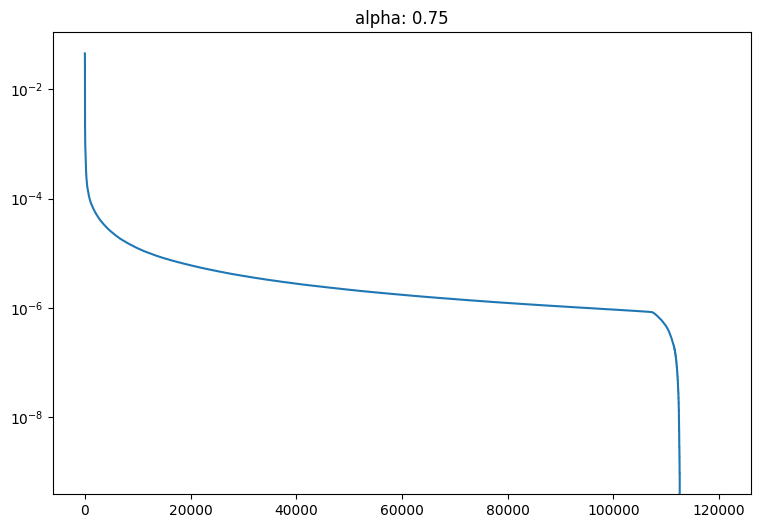

<Figure size 640x480 with 0 Axes>

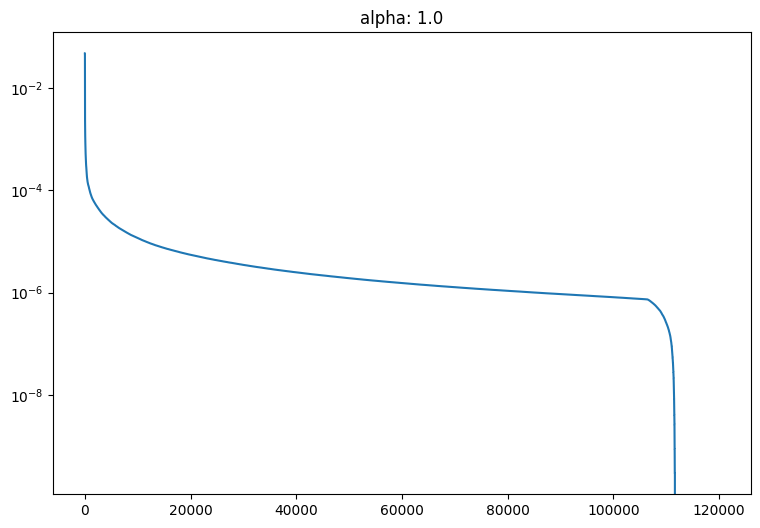

In [11]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

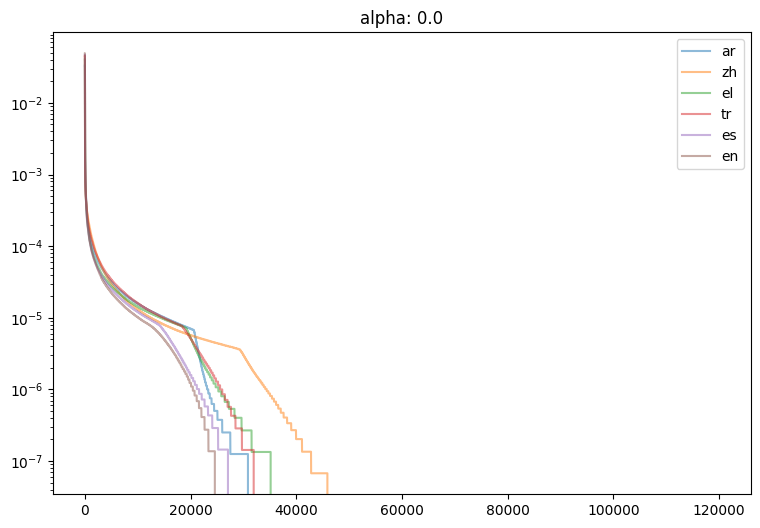

<Figure size 640x480 with 0 Axes>

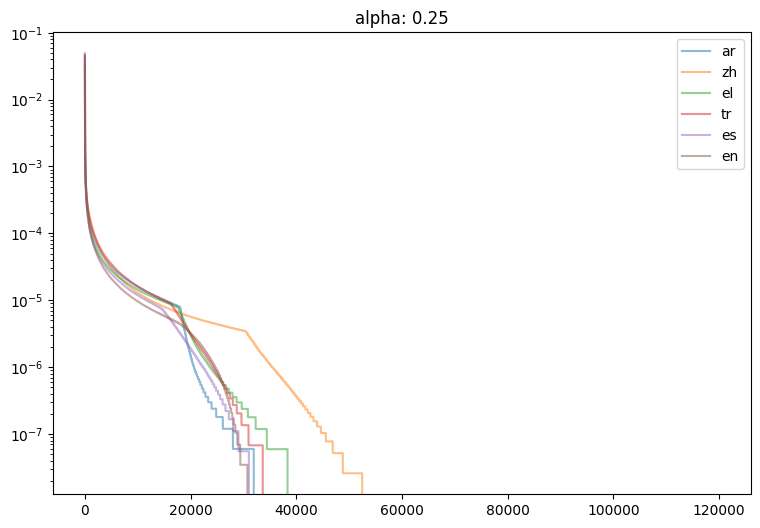

<Figure size 640x480 with 0 Axes>

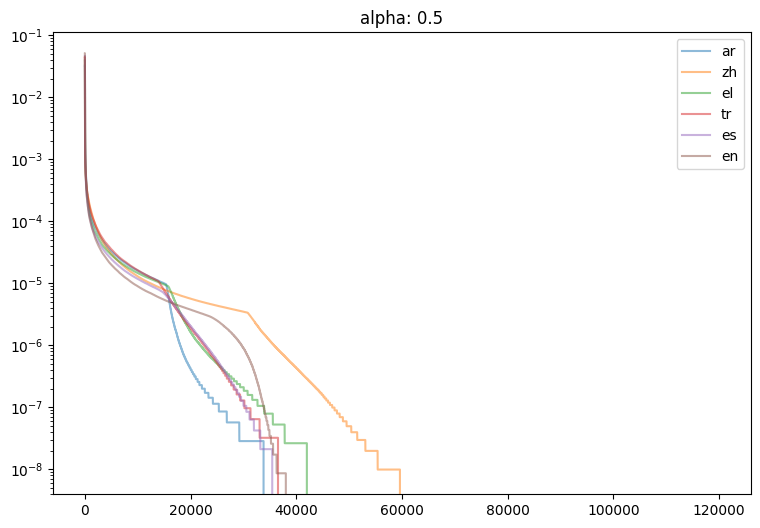

<Figure size 640x480 with 0 Axes>

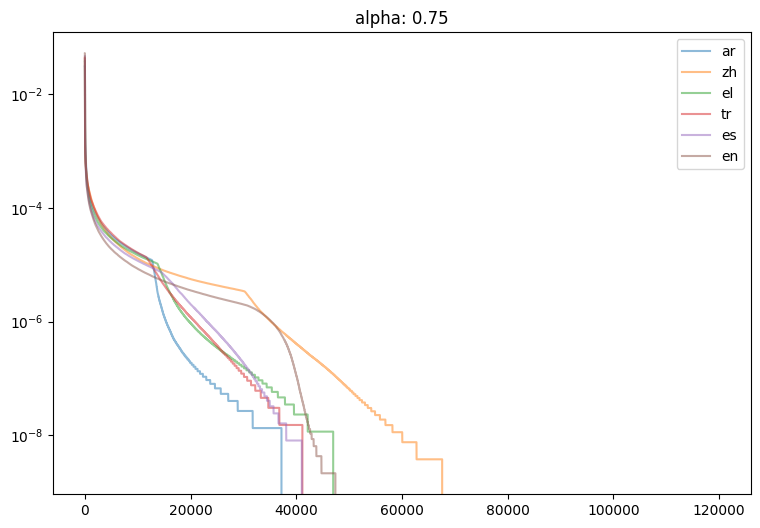

<Figure size 640x480 with 0 Axes>

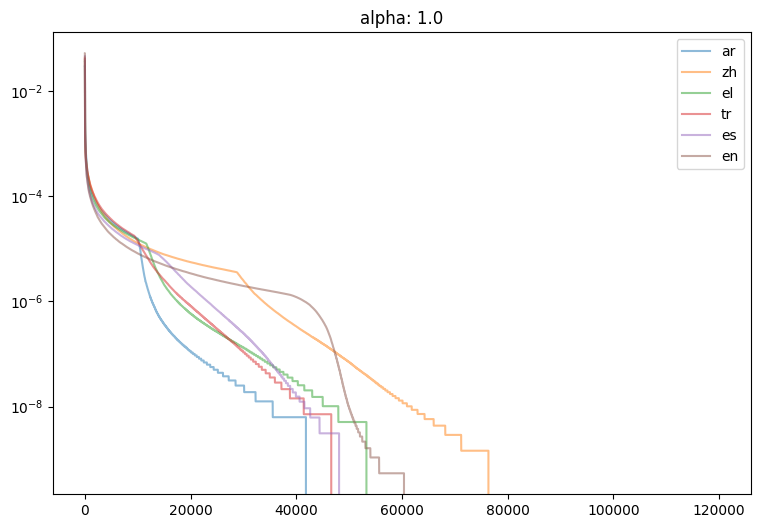

In [12]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

        

<Figure size 640x480 with 0 Axes>

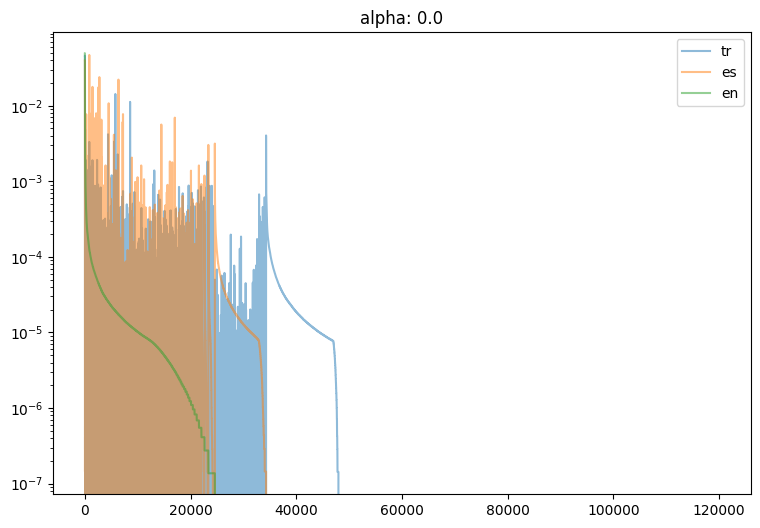

<Figure size 640x480 with 0 Axes>

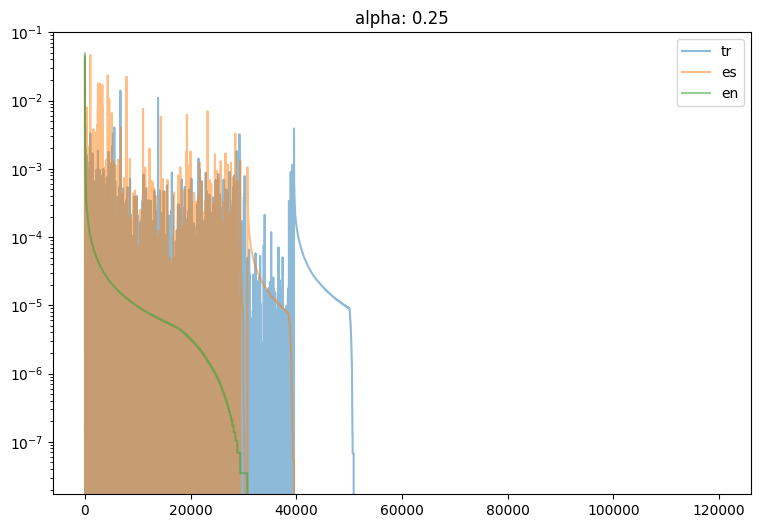

<Figure size 640x480 with 0 Axes>

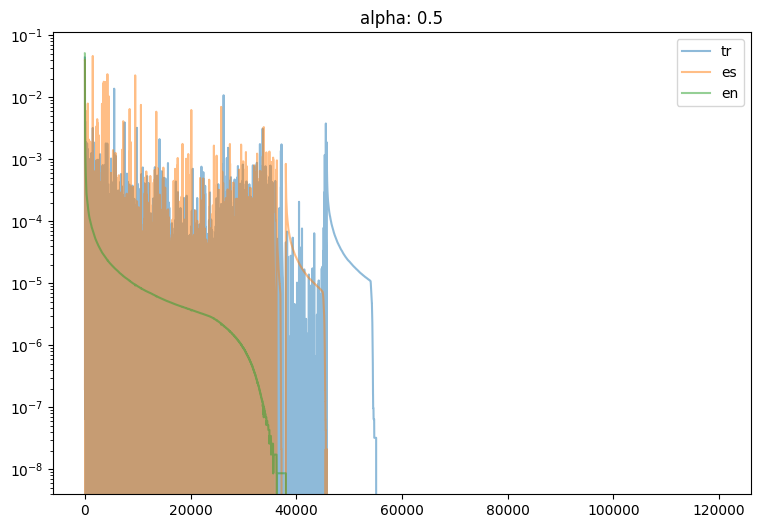

<Figure size 640x480 with 0 Axes>

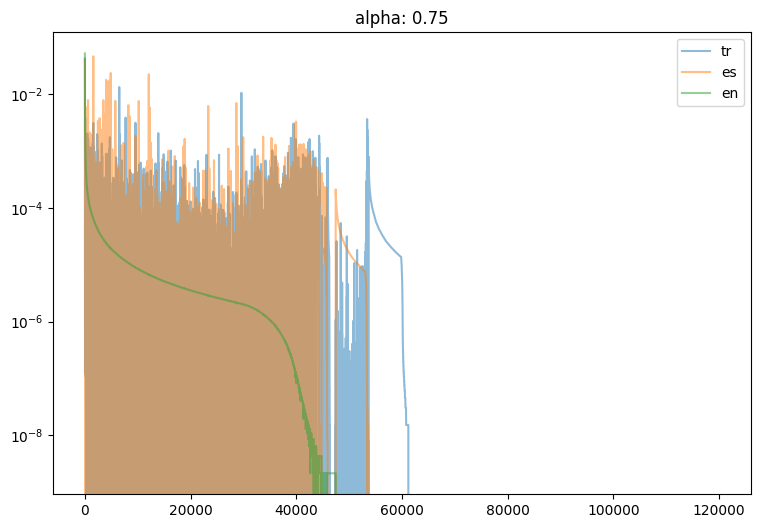

<Figure size 640x480 with 0 Axes>

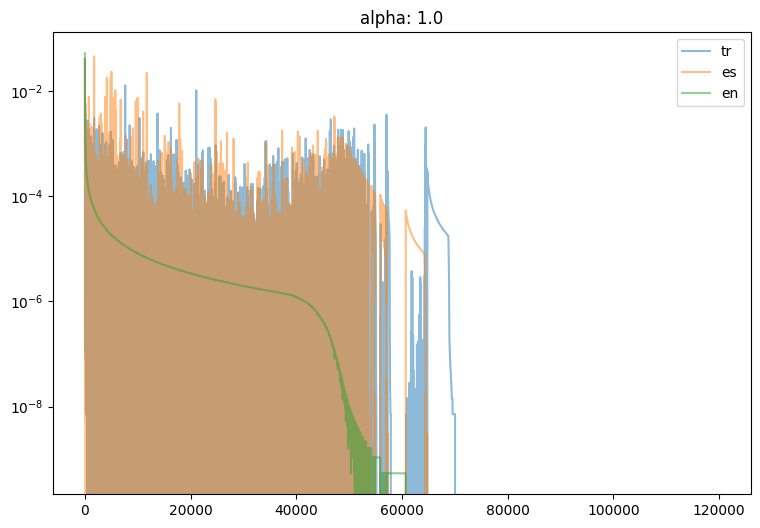

In [13]:
langugage_subset = ('tr','es', 'en')
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    index_sort_key = np.zeros_like(overall_token_dists[alpha])
    for lang_idx, lang in enumerate(langugage_subset):
        index_sort_key -= token_dists[alpha][lang] * pow(100000, lang_idx)
    index_sort = np.argsort(index_sort_key)
    for lang in langugage_subset:
        ax.plot(token_dists[alpha][lang][index_sort], label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()


# CDFs

<Figure size 640x480 with 0 Axes>

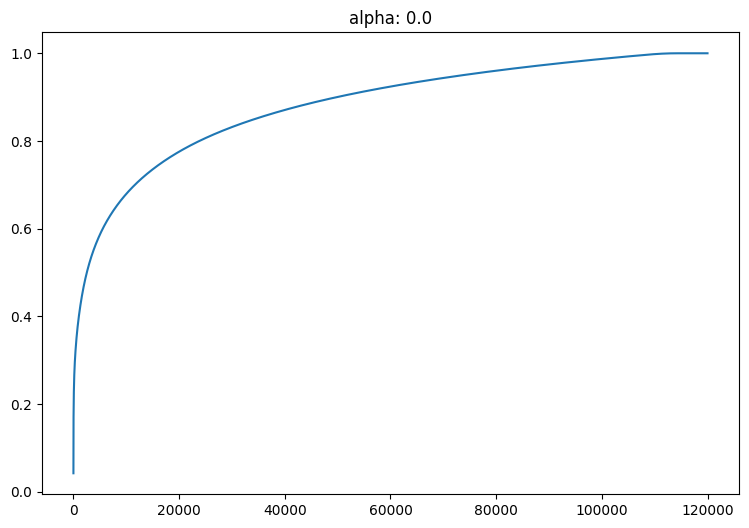

quatniles: 0.90, 0.95, 0.99, 0.999: [49825, 73616, 102442, 111201]
average rank: 14264


<Figure size 640x480 with 0 Axes>

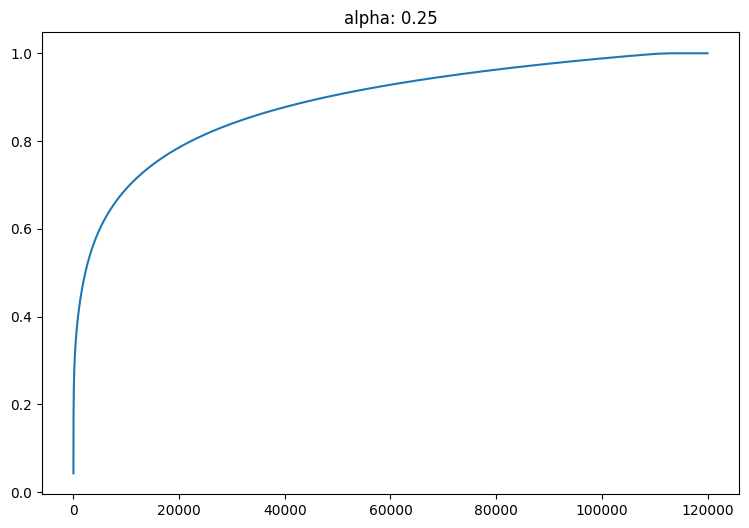

quatniles: 0.90, 0.95, 0.99, 0.999: [47790, 71823, 101592, 110717]
average rank: 13645


<Figure size 640x480 with 0 Axes>

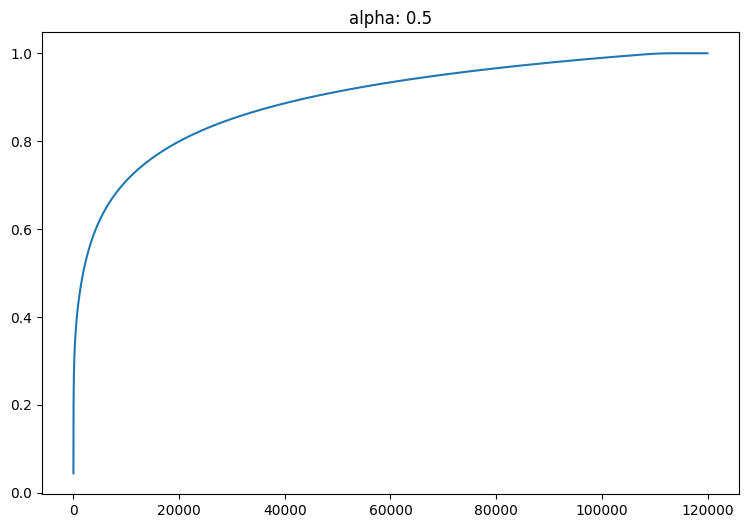

quatniles: 0.90, 0.95, 0.99, 0.999: [44850, 69187, 100368, 110036]
average rank: 12758


<Figure size 640x480 with 0 Axes>

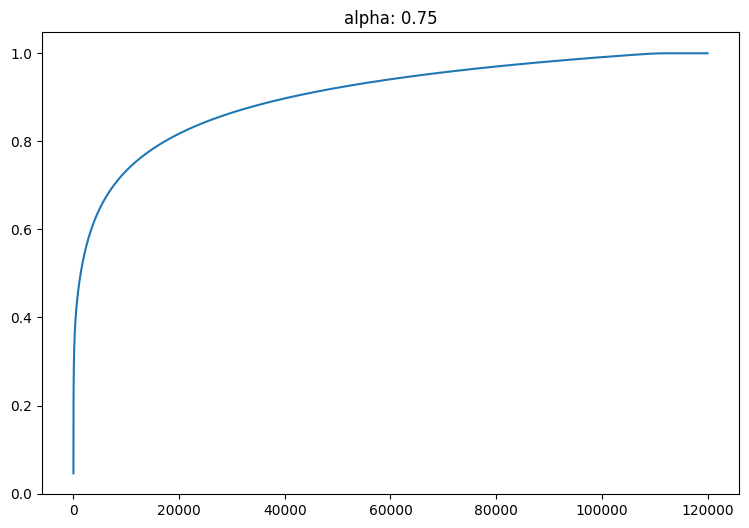

quatniles: 0.90, 0.95, 0.99, 0.999: [40905, 65509, 98678, 109176]
average rank: 11640


<Figure size 640x480 with 0 Axes>

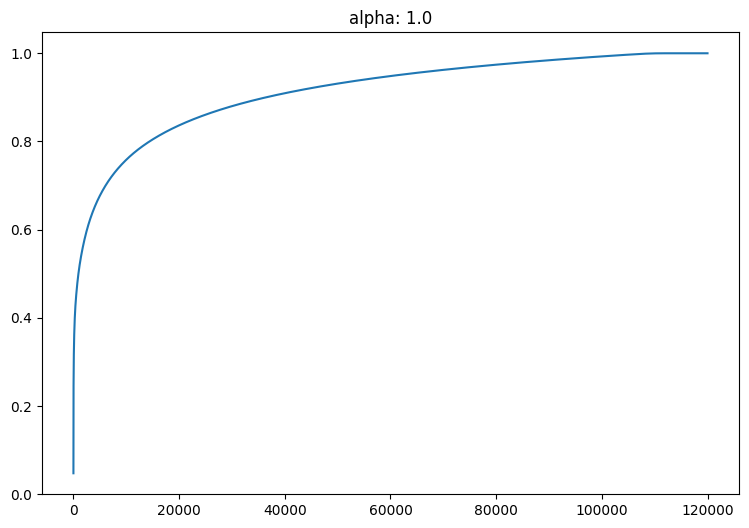

quatniles: 0.90, 0.95, 0.99, 0.999: [36416, 61070, 96461, 108058]
average rank: 10447


In [14]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()



    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

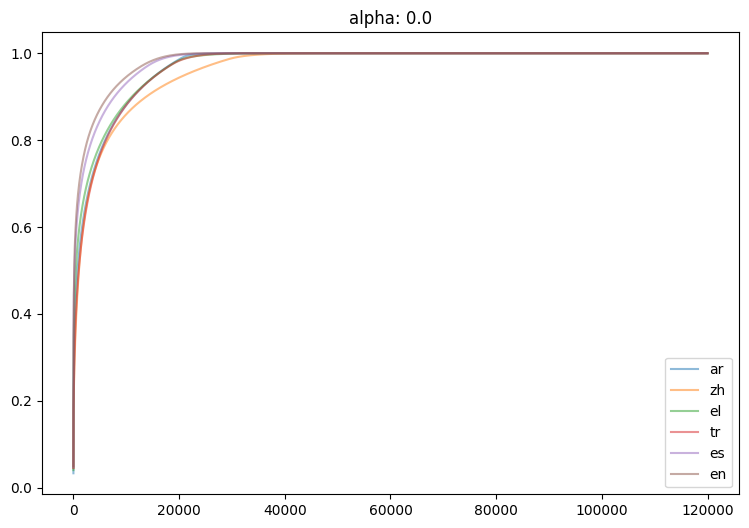

ar percentiles: 0.90, 0.95, 0.99, 0.999: [11278, 15621, 20580, 25449]
ar average rang: 3321
zh percentiles: 0.90, 0.95, 0.99, 0.999: [13770, 21086, 30491, 38779]
zh average rang: 4161
el percentiles: 0.90, 0.95, 0.99, 0.999: [11046, 15652, 21607, 29613]
el average rang: 3104
tr percentiles: 0.90, 0.95, 0.99, 0.999: [11305, 15720, 21791, 27706]
tr average rang: 3465
es percentiles: 0.90, 0.95, 0.99, 0.999: [7749, 11707, 17518, 23177]
es average rang: 2161
en percentiles: 0.90, 0.95, 0.99, 0.999: [6492, 10435, 16514, 21375]
en average rang: 1836


<Figure size 640x480 with 0 Axes>

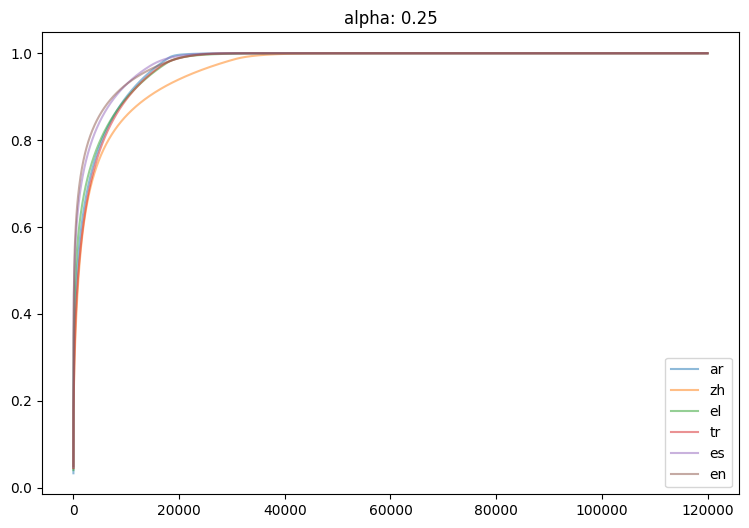

ar percentiles: 0.90, 0.95, 0.99, 0.999: [10044, 13824, 18096, 23623]
ar average rang: 2972
zh percentiles: 0.90, 0.95, 0.99, 0.999: [14200, 21841, 31817, 41340]
zh average rang: 4294
el percentiles: 0.90, 0.95, 0.99, 0.999: [10266, 14533, 20270, 29765]
el average rang: 2907
tr percentiles: 0.90, 0.95, 0.99, 0.999: [10412, 14361, 20331, 27265]
tr average rang: 3226
es percentiles: 0.90, 0.95, 0.99, 0.999: [7916, 12052, 18370, 25079]
es average rang: 2220
en percentiles: 0.90, 0.95, 0.99, 0.999: [7491, 12583, 20422, 25839]
en average rang: 2143


<Figure size 640x480 with 0 Axes>

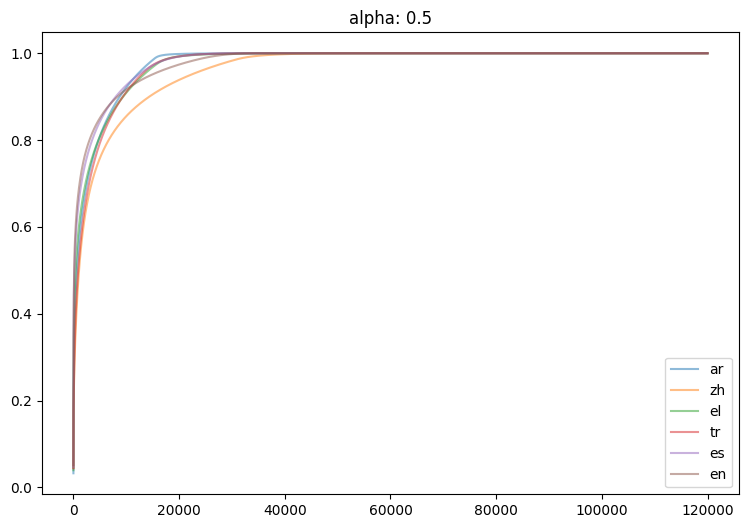

ar percentiles: 0.90, 0.95, 0.99, 0.999: [8753, 11981, 15581, 21571]
ar average rang: 2604
zh percentiles: 0.90, 0.95, 0.99, 0.999: [14346, 22125, 32360, 43215]
zh average rang: 4344
el percentiles: 0.90, 0.95, 0.99, 0.999: [9398, 13230, 18628, 29553]
el average rang: 2689
tr percentiles: 0.90, 0.95, 0.99, 0.999: [9351, 12795, 18725, 26795]
tr average rang: 2932
es percentiles: 0.90, 0.95, 0.99, 0.999: [8006, 12256, 18945, 26633]
es average rang: 2249
en percentiles: 0.90, 0.95, 0.99, 0.999: [8315, 14713, 25052, 31027]
en average rang: 2431


<Figure size 640x480 with 0 Axes>

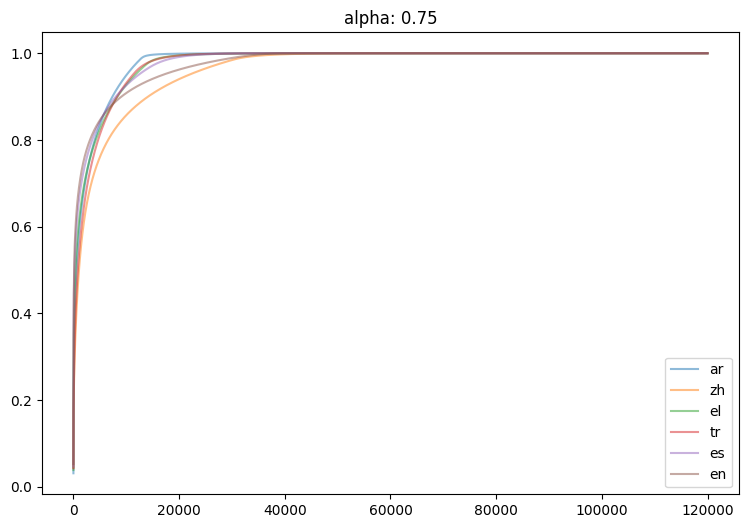

ar percentiles: 0.90, 0.95, 0.99, 0.999: [7380, 10044, 13006, 19615]
ar average rang: 2209
zh percentiles: 0.90, 0.95, 0.99, 0.999: [14115, 21794, 32008, 44327]
zh average rang: 4288
el percentiles: 0.90, 0.95, 0.99, 0.999: [8313, 11653, 16700, 29204]
el average rang: 2408
tr percentiles: 0.90, 0.95, 0.99, 0.999: [8275, 11220, 17156, 26879]
tr average rang: 2635
es percentiles: 0.90, 0.95, 0.99, 0.999: [8025, 12289, 19337, 28188]
es average rang: 2266
en percentiles: 0.90, 0.95, 0.99, 0.999: [9078, 16859, 30393, 37279]
en average rang: 2728


<Figure size 640x480 with 0 Axes>

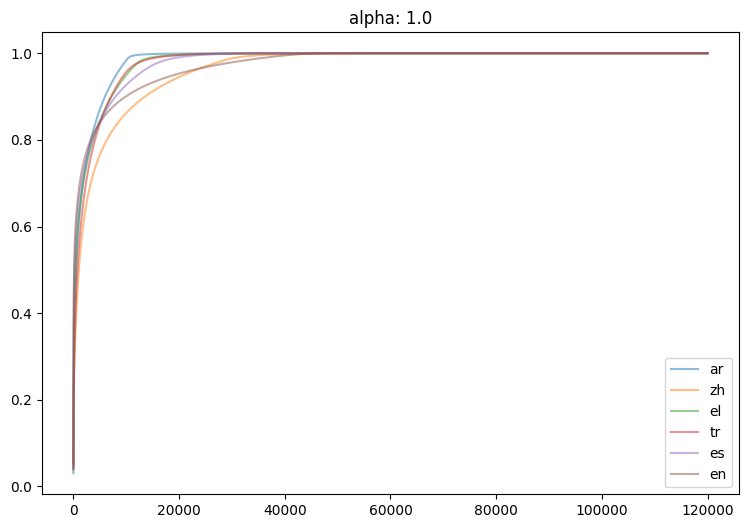

ar percentiles: 0.90, 0.95, 0.99, 0.999: [5972, 8086, 10461, 17653]
ar average rang: 1804
zh percentiles: 0.90, 0.95, 0.99, 0.999: [13540, 20872, 30768, 44651]
zh average rang: 4133
el percentiles: 0.90, 0.95, 0.99, 0.999: [7212, 10011, 14679, 28936]
el average rang: 2121
tr percentiles: 0.90, 0.95, 0.99, 0.999: [7109, 9538, 15611, 26865]
tr average rang: 2316
es percentiles: 0.90, 0.95, 0.99, 0.999: [7975, 12174, 19578, 29860]
es average rang: 2266
en percentiles: 0.90, 0.95, 0.99, 0.999: [9876, 19072, 36306, 44391]
en average rang: 3056


In [15]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")
        